<!-- # 라이브러리 불러오기 -->

In [ ]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import koreanize_matplotlib
import time
import math
from tqdm.notebook import tqdm
import itertools
from skimage.filters import gabor_kernel
from scipy.ndimage import convolve
from skimage.morphology import (
    skeletonize, closing, opening, disk, remove_small_objects
)
from os.path import join, basename, splitext
from scipy.spatial import cKDTree
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
plt.rcParams['figure.figsize'] = (8, 8)

<!-- # 데이터 일부 확인
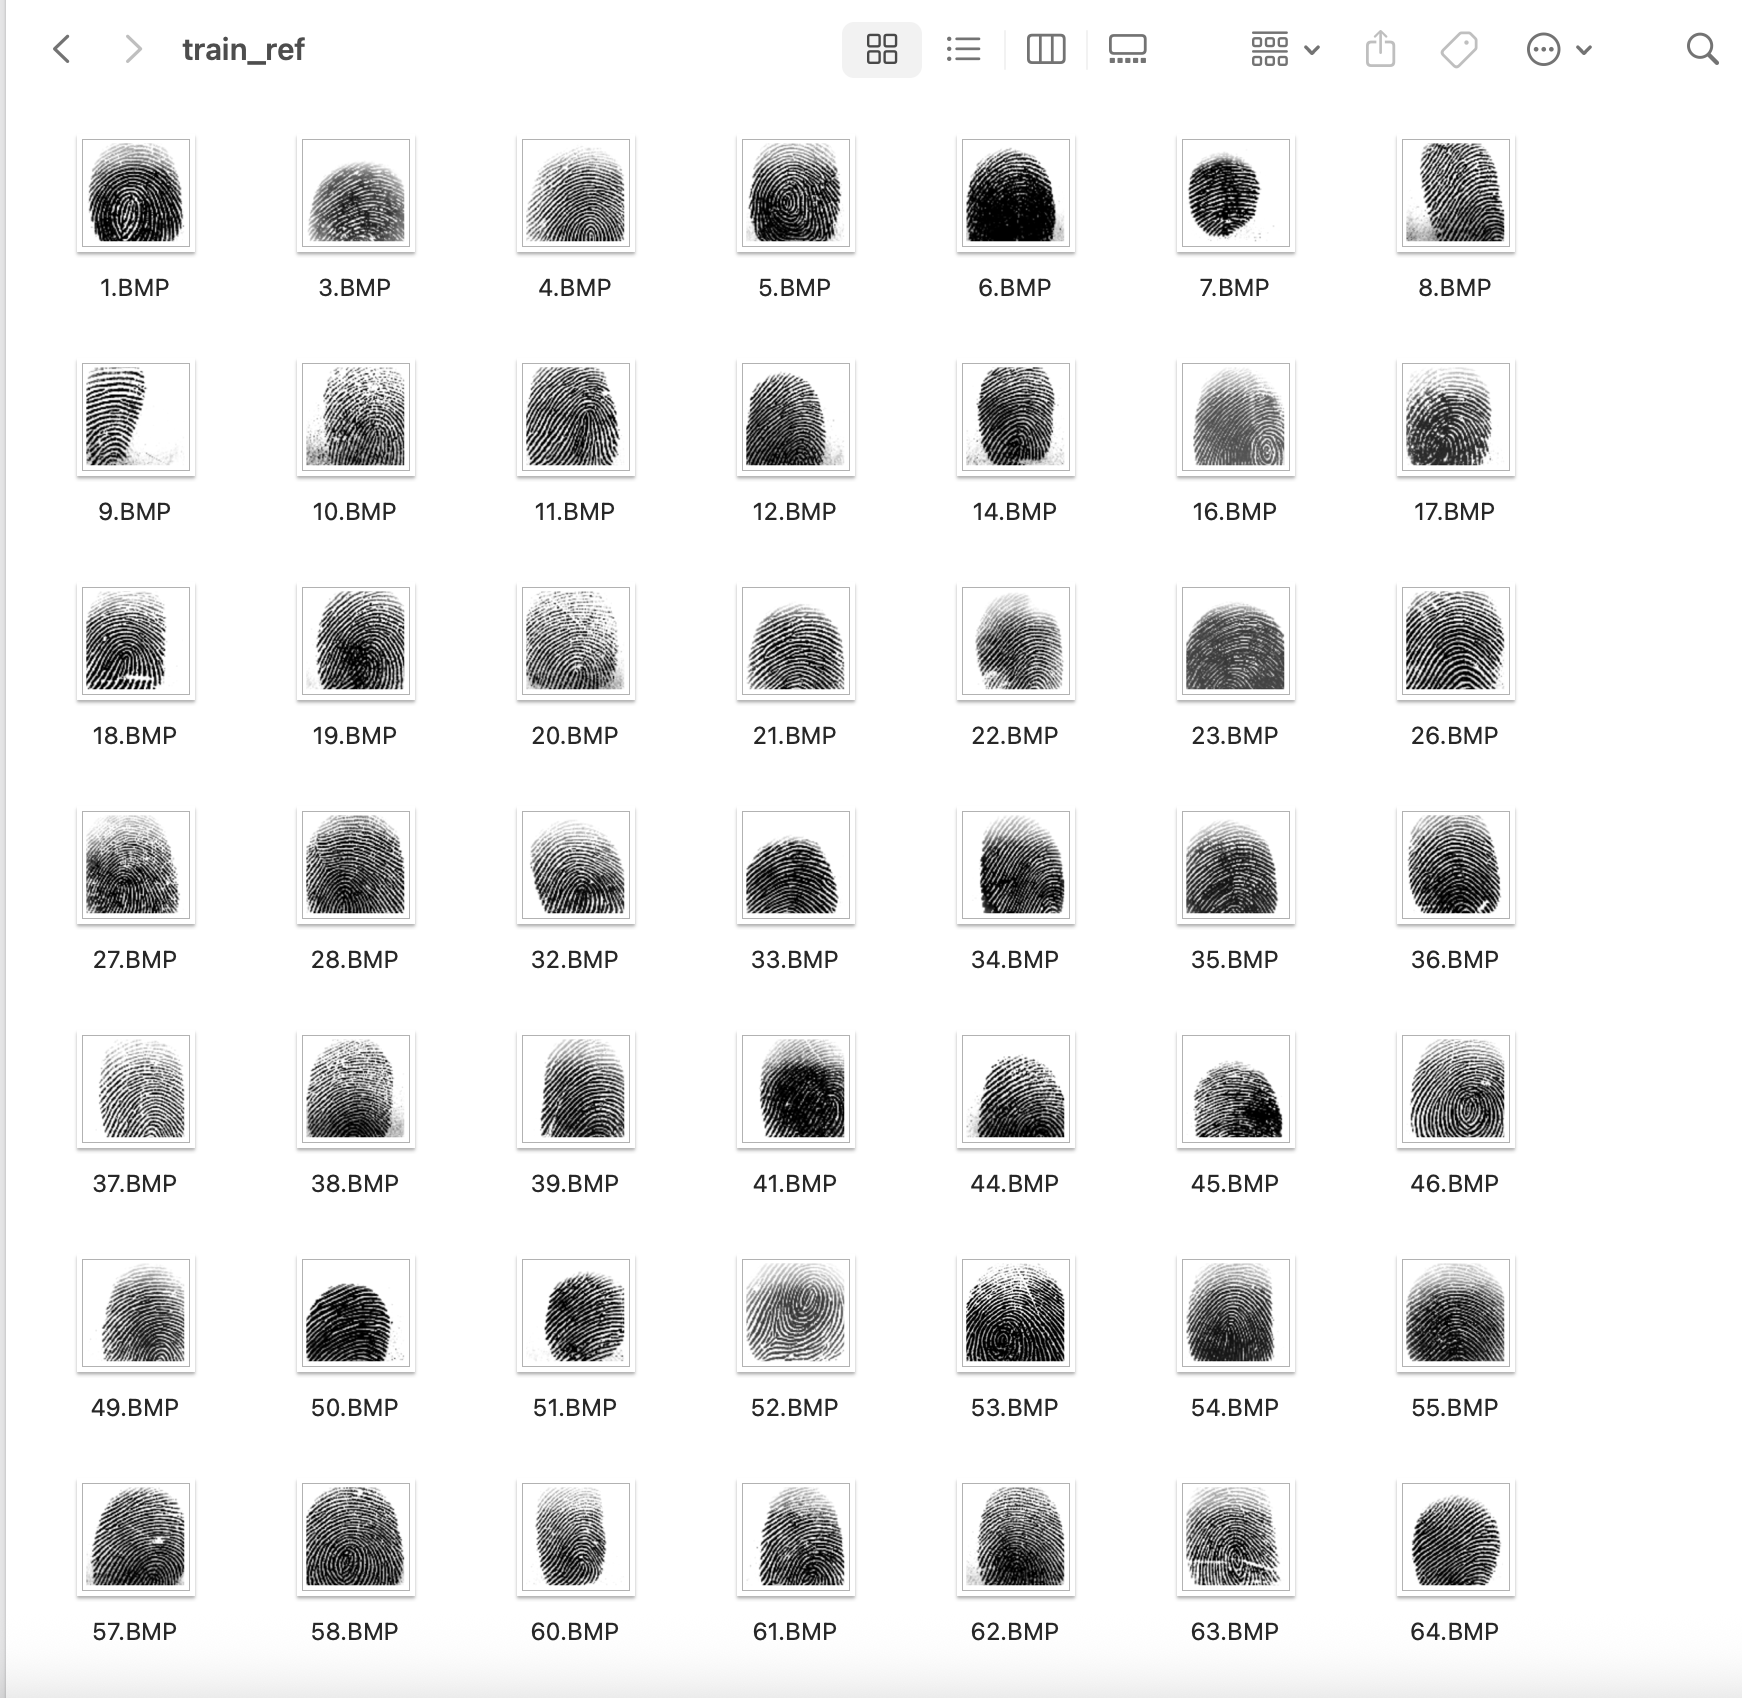 -->

In [ ]:
ls

20250519_hw5_fingerprint_recognition_tkwoo.pdf
__pycache__/
checkpoints/
hw5.ipynb
minutiae/
processed_images/
test/
test2/
train_ref/


65536
(256, 256)


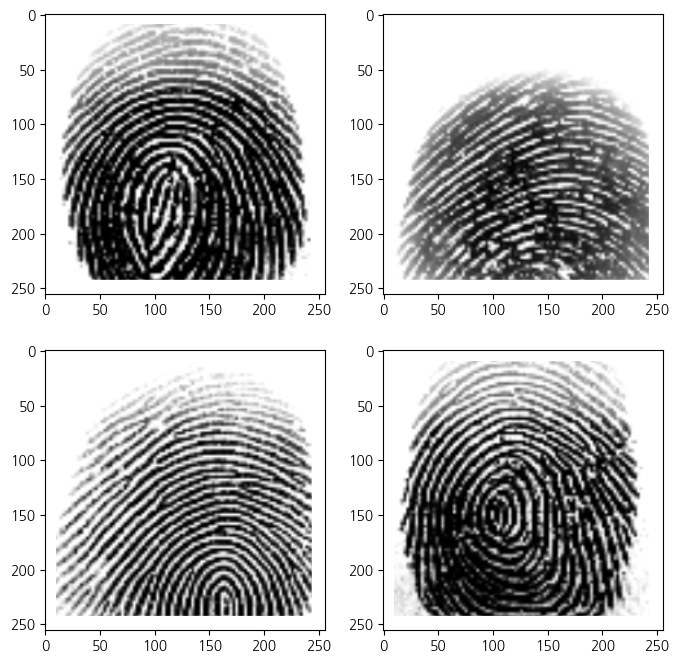

In [ ]:
img1 = cv2.imread('./train_ref/1.BMP', 0)
img2 = cv2.imread('./train_ref/3.BMP', 0)
img3 = cv2.imread('./train_ref/4.BMP', 0)
img4 = cv2.imread('./train_ref/5.BMP', 0)

plt.subplot(2,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(img2, cmap='gray')
plt.subplot(2,2,3)
plt.imshow(img3, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(img4, cmap='gray')

print(img1.size) # 256*256
print(img1.shape) # (256, 256)

In [ ]:
train_data = os.listdir("./train_ref")
test_data = os.listdir("./test")
test_data2 = os.listdir("./test2")

len(train_data), len(test_data), len(test_data2) 

(477, 477, 1429)

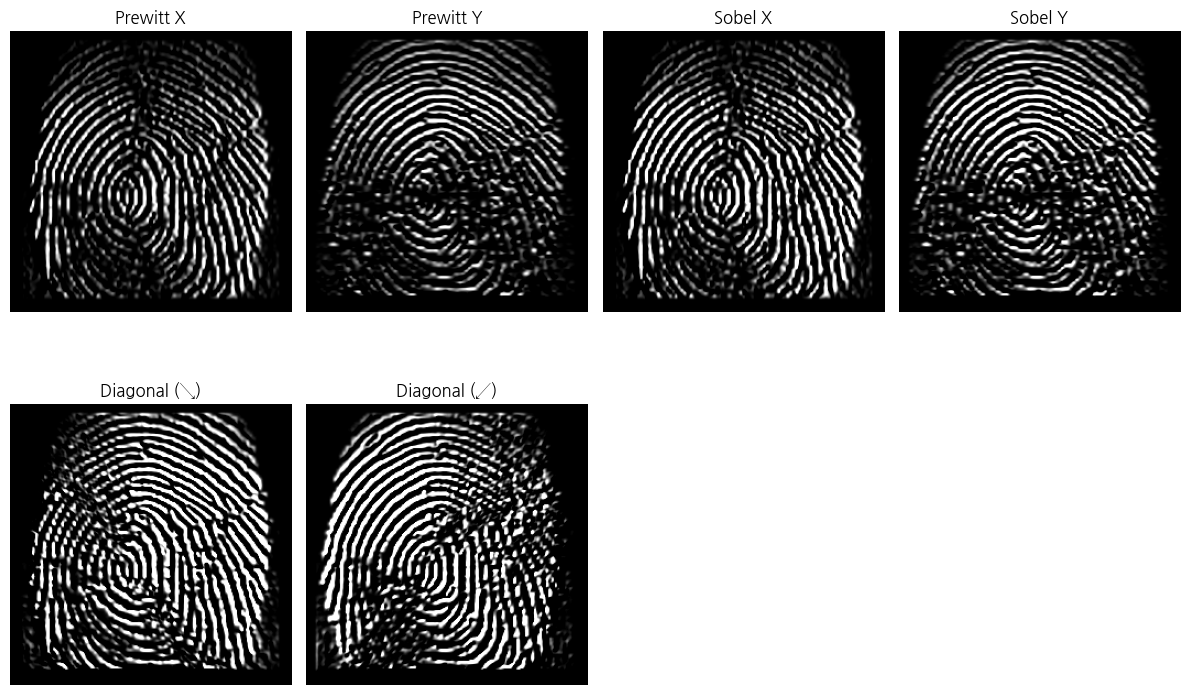

In [ ]:
# 3x3 커널 정의
kernels = {
    "Prewitt X": np.array([[-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1]], dtype=np.float32),
    
    "Prewitt Y": np.array([[1, 1, 1],
                           [0, 0, 0],
                           [-1, -1, -1]], dtype=np.float32),

    "Sobel X": np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], dtype=np.float32),

    "Sobel Y": np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]], dtype=np.float32),

    "Diagonal (↘)": np.array([[0, 1, 4],
                              [-1, 0, 1],
                              [-4, -1, 0]], dtype=np.float32),

    "Diagonal (↙)": np.array([[4, 1, 0],
                              [1, 0, -1],
                              [0, -1, -4]], dtype=np.float32),
    

}

plt.figure(figsize=(12, 8))

img_blur = cv2.GaussianBlur(img4, (3, 3), 0)  

for idx, (label, kernel) in enumerate(kernels.items()):

    filtered = cv2.filter2D(img_blur, -1, kernel)
    plt.subplot(2, 4, idx + 1)
    plt.imshow(filtered, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

<!-- # 데이터 전처리 -->

Endpoints: 68, Bifurcations: 28


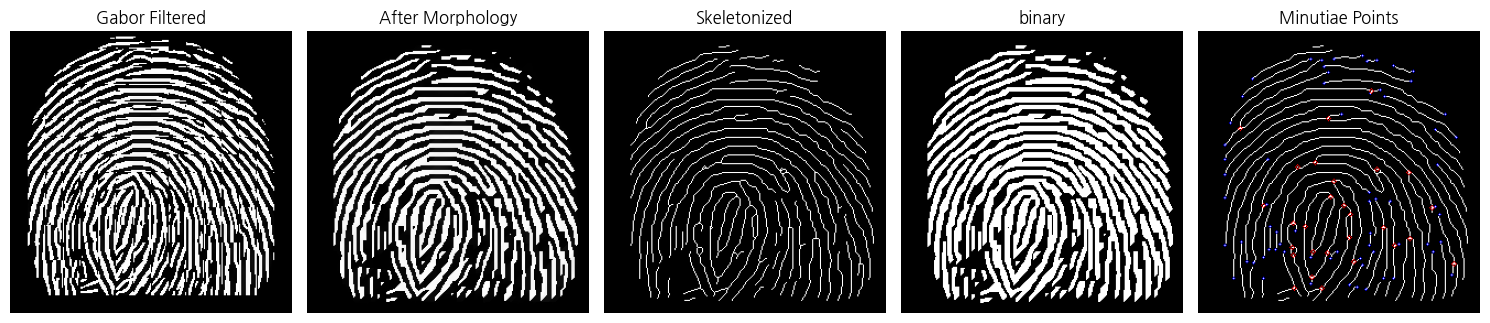

In [ ]:
def compute_orientation_field(img, block_size=32): 
    # 블록마다 방향성을 계산하는 함수 정의 -> 지문의 블록마다 방향성을 계산
    h, w = img.shape
    ori_field = np.zeros((h // block_size, w // block_size)) # 방향성 필드를 저장할 배열 초기화

    # 블록 단위로 이미지 순회
    for i in range(0, h - block_size, block_size):
        for j in range(0, w - block_size, block_size):
            block = img[i:i+block_size, j:j+block_size]
            if np.std(block) < 10:
                continue
            gy, gx = np.gradient(block.astype(np.float32))
            vxx = np.sum(2 * gx * gy)
            vyy = np.sum(gx**2 - gy**2)
            angle = 0.5 * np.arctan2(vxx, vyy)
            ori_field[i // block_size, j // block_size] = angle
    return ori_field

def apply_gabor_filter(img, ori_field, block_size=32): 
    h, w = img.shape 
    gabor_img = np.zeros_like(img, dtype=np.float32)

    for i in range(0, h - block_size, block_size):
        for j in range(0, w - block_size, block_size):
            angle = ori_field[i // block_size, j // block_size] 
            block = img[i:i+block_size, j:j+block_size]
            if block.shape != (block_size, block_size) or np.std(block) < 10:
                continue
            kernel = gabor_kernel(frequency=0.2, theta=angle, sigma_x=3.0, sigma_y=3.0).real
            filtered = convolve(block, kernel)
            gabor_img[i:i+block_size, j:j+block_size] = filtered

    gabor_img = cv2.normalize(gabor_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return gabor_img

def get_foreground_mask(binary, kernel_size=5): # 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size)) 
    mask = cv2.dilate(binary.astype(np.uint8), kernel, iterations=3)
    return mask

def suppress_nearby_points(points, min_dist=5):
    kept = []
    for (x, y) in points:
        if all(np.hypot(x - px, y - py) >= min_dist for px, py in kept):
            kept.append((x, y))
    return kept

def orientation_gabor_morphology(img_input, block_size=32):
    img_blur = cv2.GaussianBlur(img_input, (3, 3), 0)

    ori_field = compute_orientation_field(img_blur, block_size=block_size)

    gabor_result = apply_gabor_filter(img_blur, ori_field, block_size=block_size)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    morphed = gabor_result.copy()
    for _ in range(4): 
        morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
        morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, kernel, iterations=1)

    _, binary = cv2.threshold(morphed, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    binary = cv2.dilate(binary, kernel, iterations=1)
    
    skeleton = skeletonize(binary).astype(np.uint8) * 255

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(skeleton, connectivity=8) # 좀 더 연결 해주기 위해 
    cleaned = np.zeros_like(skeleton) # 이걸 추가한 이유는 너무 짧은 선분을 제거하기 위해서
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= 10:
            cleaned[labels == i] = 255

    return gabor_result, morphed, cleaned, binary

def get_minutiae(skeleton, mask, margin=20):
    skeleton = (skeleton > 0).astype(np.uint8)
    endpoints = []
    bifurcations = []
    h, w = skeleton.shape
    padded = np.pad(skeleton, ((1, 1), (1, 1)), mode='constant')
    for y in range(1, h + 1):
        for x in range(1, w + 1):
            if padded[y, x] == 1:
                P = [
                    padded[y - 1, x], padded[y - 1, x + 1], padded[y, x + 1],
                    padded[y + 1, x + 1], padded[y + 1, x], padded[y + 1, x - 1],
                    padded[y, x - 1], padded[y - 1, x - 1]
                ]
                cn = sum(abs(int(P[i]) - int(P[(i + 1) % 8])) for i in range(8)) // 2
                px, py = x - 1, y - 1
                if mask[py, px] > 0 and margin <= px < w - margin and margin <= py < h - margin:
                    if cn == 1:
                        endpoints.append((px, py))
                    elif cn == 3:
                        bifurcations.append((px, py))
    endpoints = suppress_nearby_points(endpoints, min_dist=6)
    bifurcations = suppress_nearby_points(bifurcations, min_dist=6)
    return np.array(endpoints, dtype=np.int32), np.array(bifurcations, dtype=np.int32)

def draw_minutiae(img, endpoints, bifurcations):
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x, y in endpoints:
        cv2.circle(img_color, (x, y), 1, (255, 0, 0), 1) 
    for x, y in bifurcations:
        cv2.circle(img_color, (x, y), 2, (0, 0, 255), 1) 
    return img_color

gabor_result, morphed_result, skeleton_result, binary = orientation_gabor_morphology(img1, block_size=16)

foreground_mask = get_foreground_mask(binary)
endpoints, bifurcations = get_minutiae(skeleton_result, foreground_mask)
skeleton_result2 = draw_minutiae(skeleton_result, endpoints, bifurcations)

plt.figure(figsize=(15, 4))
plt.subplot(1, 5, 1)
plt.imshow(gabor_result, cmap='gray')
plt.title("Gabor Filtered")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(morphed_result, cmap='gray')
plt.title("After Morphology")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(skeleton_result, cmap='gray')
plt.title("Skeletonized")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(binary, cmap='gray')
plt.title("binary")
plt.axis('off')

print(f"Endpoints: {len(endpoints)}, Bifurcations: {len(bifurcations)}")

plt.subplot(1, 5, 5)
plt.imshow(cv2.cvtColor(skeleton_result2, cv2.COLOR_BGR2RGB))
plt.title("Minutiae Points")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dir_path = "./train_ref"
train_data = sorted(glob(join(dir_path, '*.BMP')))

output_dir_skel= f'./processed_images/{dir_path}'
output_dir_minutia= f'./minutiae/{dir_path}'
os.makedirs(output_dir_skel,exist_ok=True)
os.makedirs(output_dir_minutia, exist_ok=True)

def process_image(img_path, block_size=16):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gabor_result, morphed_result, skeleton_result, binary_result = orientation_gabor_morphology(img, block_size=block_size)
    foreground_mask = get_foreground_mask(binary_result)
    endpoints, bifurcations = get_minutiae(skeleton_result, foreground_mask)
    skeleton_with_minutiae = draw_minutiae(skeleton_result, endpoints, bifurcations)
    return img, gabor_result, morphed_result, skeleton_result, binary_result, skeleton_with_minutiae, endpoints, bifurcations


results = []
for img_path in tqdm(train_data, desc="Processing Images"):
    (original, gabor_result, morphed_result,
     skeleton_result, binary_result,
     skeleton_min, endpoints, bifurcations) = process_image(img_path)

    fname = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite(join(output_dir_skel, f'{fname}_skeleton.png'), skeleton_result)
    cv2.imwrite(join(output_dir_skel, f'{fname}_skeleton_minutiae.png'), skeleton_min)

    np.save(join(output_dir_minutia, f'{fname}_endpoints.npy'), endpoints)
    np.save(join(output_dir_minutia, f'{fname}_bifurcations.npy'), bifurcations)

for idx, (original, gabor_result, morphed_result, skeleton_result, binary_result, skeleton_min) in enumerate(results[:4]):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 6, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original {idx}")
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(gabor_result, cmap='gray')
    plt.title("Gabor")
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(morphed_result, cmap='gray')
    plt.title("Morphology")
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(skeleton_result, cmap='gray')
    plt.title("Skeleton")
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(binary_result, cmap='gray')
    plt.title("Binary")
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(cv2.cvtColor(skeleton_min, cv2.COLOR_BGR2RGB))
    plt.title("Minutiae")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing Images:   0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
dir_path = "./test"
train_data = sorted(glob(join(dir_path, '*.BMP')))

output_dir_skel= f'./processed_images/{dir_path}'
output_dir_minutia= f'./minutiae/{dir_path}'
os.makedirs(output_dir_skel,exist_ok=True)
os.makedirs(output_dir_minutia, exist_ok=True)

def process_image(img_path, block_size=16):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gabor_result, morphed_result, skeleton_result, binary_result = orientation_gabor_morphology(img, block_size=block_size)
    foreground_mask = get_foreground_mask(binary_result)
    endpoints, bifurcations = get_minutiae(skeleton_result, foreground_mask)
    skeleton_with_minutiae = draw_minutiae(skeleton_result, endpoints, bifurcations)
    return img, gabor_result, morphed_result, skeleton_result, binary_result, skeleton_with_minutiae, endpoints, bifurcations


results = []
for img_path in tqdm(train_data, desc="Processing Images"):
    (original, gabor_result, morphed_result,
     skeleton_result, binary_result,
     skeleton_min, endpoints, bifurcations) = process_image(img_path)

    fname = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite(join(output_dir_skel, f'{fname}_skeleton.png'), skeleton_result)
    cv2.imwrite(join(output_dir_skel, f'{fname}_skeleton_minutiae.png'), skeleton_min)

    np.save(join(output_dir_minutia, f'{fname}_endpoints.npy'), endpoints)
    np.save(join(output_dir_minutia, f'{fname}_bifurcations.npy'), bifurcations)

for idx, (original, gabor_result, morphed_result, skeleton_result, binary_result, skeleton_min) in enumerate(results[:4]):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 6, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original {idx}")
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(gabor_result, cmap='gray')
    plt.title("Gabor")
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(morphed_result, cmap='gray')
    plt.title("Morphology")
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(skeleton_result, cmap='gray')
    plt.title("Skeleton")
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(binary_result, cmap='gray')
    plt.title("Binary")
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(cv2.cvtColor(skeleton_min, cv2.COLOR_BGR2RGB))
    plt.title("Minutiae")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing Images:   0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
dir_path = "./test2"
train_data = sorted(glob(join(dir_path, '*.BMP')))

output_dir_skel= f'./processed_images/{dir_path}'
output_dir_minutia= f'./minutiae/{dir_path}'
os.makedirs(output_dir_skel,exist_ok=True)
os.makedirs(output_dir_minutia, exist_ok=True)

def process_image(img_path, block_size=16):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gabor_result, morphed_result, skeleton_result, binary_result = orientation_gabor_morphology(img, block_size=block_size)
    foreground_mask = get_foreground_mask(binary_result)
    endpoints, bifurcations = get_minutiae(skeleton_result, foreground_mask)
    skeleton_with_minutiae = draw_minutiae(skeleton_result, endpoints, bifurcations)
    return img, gabor_result, morphed_result, skeleton_result, binary_result, skeleton_with_minutiae, endpoints, bifurcations


results = []
for img_path in tqdm(train_data, desc="Processing Images"):
    (original, gabor_result, morphed_result,
     skeleton_result, binary_result,
     skeleton_min, endpoints, bifurcations) = process_image(img_path)

    fname = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite(join(output_dir_skel, f'{fname}_skeleton.png'), skeleton_result)
    cv2.imwrite(join(output_dir_skel, f'{fname}_skeleton_minutiae.png'), skeleton_min)

    np.save(join(output_dir_minutia, f'{fname}_endpoints.npy'), endpoints)
    np.save(join(output_dir_minutia, f'{fname}_bifurcations.npy'), bifurcations)

for idx, (original, gabor_result, morphed_result, skeleton_result, binary_result, skeleton_min) in enumerate(results[:4]):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 6, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original {idx}")
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(gabor_result, cmap='gray')
    plt.title("Gabor")
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(morphed_result, cmap='gray')
    plt.title("Morphology")
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(skeleton_result, cmap='gray')
    plt.title("Skeleton")
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(binary_result, cmap='gray')
    plt.title("Binary")
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(cv2.cvtColor(skeleton_min, cv2.COLOR_BGR2RGB))
    plt.title("Minutiae")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing Images:   0%|          | 0/1428 [00:00<?, ?it/s]

In [22]:
# 시간 줄이기 위해 캐싱을 사용
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

@lru_cache(maxsize=128)
def get_cached_kernel(theta):
    return gabor_kernel(frequency=0.2, theta=theta, sigma_x=3.0, sigma_y=3.0).real

def compute_orientation_field(img, block_size=32):
    h, w = img.shape
    ori_field = np.zeros((h//block_size, w//block_size), dtype=np.float32)
    for i in range(0, h-block_size, block_size):
        for j in range(0, w-block_size, block_size):
            block = img[i:i+block_size, j:j+block_size]
            if np.std(block) < 10:
                continue
            gy, gx = np.gradient(block.astype(np.float32))
            vxx = np.sum(2*gx*gy)
            vyy = np.sum(gx**2 - gy**2)
            ori_field[i//block_size, j//block_size] = 0.5 * np.arctan2(vxx, vyy)
    return ori_field

def apply_gabor_filter(img, ori_field, block_size=32):
    h, w = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    for i in range(0, h-block_size, block_size):
        for j in range(0, w-block_size, block_size):
            angle = ori_field[i//block_size, j//block_size]
            block = img[i:i+block_size, j:j+block_size]
            if block.shape != (block_size, block_size) or np.std(block) < 10:
                continue
            kernel = get_cached_kernel(angle)
            out[i:i+block_size, j:j+block_size] = convolve(block, kernel)
    return cv2.normalize(out, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def get_foreground_mask(binary, kernel_size=5):
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(binary.astype(np.uint8), kern, iterations=3)

def suppress_nearby_points(points, min_dist=5):
    kept = []
    for x,y in points:
        if all(np.hypot(x-px, y-py)>=min_dist for px,py in kept):
            kept.append((x,y))
    return kept

def orientation_gabor_morphology(img, block_size=32):
    blur = cv2.GaussianBlur(img, (3,3), 0)
    ori = compute_orientation_field(blur, block_size)
    gabor = apply_gabor_filter(blur, ori, block_size)
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    morph = gabor.copy()
    for _ in range(4):
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kern)
        morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kern)
    _, binary = cv2.threshold(morph, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binary = cv2.dilate(binary, kern)
    skel = (skeletonize(binary) * 255).astype(np.uint8)
    n, labels, stats, _ = cv2.connectedComponentsWithStats(skel, connectivity=8)
    cleaned = np.zeros_like(skel)
    for i in range(1, n):
        if stats[i, cv2.CC_STAT_AREA] >= 10:
            cleaned[labels==i] = 255
    return gabor, morph, cleaned, binary

def get_minutiae(skel, mask, margin=20):
    sk = (skel>0).astype(np.uint8)
    h,w = sk.shape
    pad = np.pad(sk, ((1,1),(1,1)), 'constant')
    ends, bifs = [], []
    for y in range(1,h+1):
        for x in range(1,w+1):
            if pad[y,x]==1:
                P = [pad[y-1,x], pad[y-1,x+1], pad[y,x+1], pad[y+1,x+1],
                     pad[y+1,x], pad[y+1,x-1], pad[y,x-1], pad[y-1,x-1]]
                cn = sum(abs(int(P[i]) - int(P[(i+1)%8])) for i in range(8))//2
                px,py = x-1,y-1
                if mask[py,px]>0 and margin<=px<w-margin and margin<=py<h-margin:
                    if cn==1: ends.append((px,py))
                    if cn==3: bifs.append((px,py))
    return (np.array(suppress_nearby_points(ends,6),np.int32),
            np.array(suppress_nearby_points(bifs,6),np.int32))

def draw_minutiae(img, ends, bifs):
    c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x,y in ends:  cv2.circle(c,(x,y),1,(255,0,0),1)
    for x,y in bifs:  cv2.circle(c,(x,y),2,(0,0,255),1)
    return c

def process_image(path, block_size=16):
    img = cv2.imread(path, 0)
    g,m,sk,b = orientation_gabor_morphology(img, block_size)
    mask = get_foreground_mask(b)
    ends,bifs = get_minutiae(sk, mask)
    vis = draw_minutiae(sk, ends, bifs)
    base = splitext(basename(path))[0]
    return base, g, m, sk, b, vis, ends, bifs

if __name__ == "__main__":
    dir_path = "./train_ref"
    out_skel = f"./processed_images2/{dir_path}"
    out_minutia = f"./minutiae2/{dir_path}"
    os.makedirs(out_skel, exist_ok=True)
    os.makedirs(out_minutia, exist_ok=True)

    all_paths = sorted(glob(join(dir_path, "*.BMP")))
    with ThreadPoolExecutor(max_workers=8) as exe:
        for base, g, m, sk, b, vis, ends, bifs in tqdm(exe.map(process_image, all_paths), total=len(all_paths)):
            cv2.imwrite(join(out_skel, f"{base}_skeleton.png"), sk)
            cv2.imwrite(join(out_skel, f"{base}_skeleton_minutiae.png"), vis)
            np.save(join(out_minutia, f"{base}_endpoints.npy"),ends)
            np.save(join(out_minutia, f"{base}_bifurcations.npy"), bifs)

  0%|          | 0/477 [00:00<?, ?it/s]

Train 개수: 477, Test2 개수: 1428
매칭 대상: 100_type1 <-> 100
Train 미뉴티에 갯수 = 63 / Test2 미뉴티에 갯수 = 76
매칭된 점쌍 개수: 63


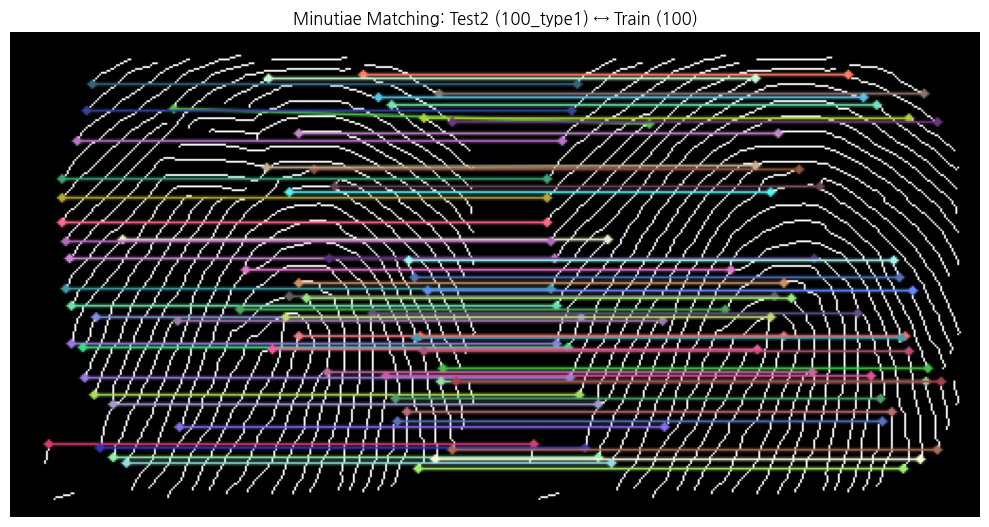

In [ ]:
def load_minutiae_coordinates(folder_path):
    npy_files = sorted(glob(join(folder_path, "*.npy")))
    minutiae_dict = {}
    for npy_path in npy_files:
        fname = splitext(basename(npy_path))[0]
        if "_" not in fname:
            key_base, kind = fname.rsplit("_", 1)
        else:
            key_base, kind = fname.rsplit("_", 1)
        coords = np.load(npy_path)
        coords = coords.astype(np.int32)
        if coords.ndim == 1:
            coords = coords.reshape(-1, 2)
        if key_base not in minutiae_dict:
            minutiae_dict[key_base] = {"endpoints": None, "bifurcations": None}
        minutiae_dict[key_base][kind] = coords
    for key_base, d in minutiae_dict.items():
        ep = d.get("endpoints")
        bf = d.get("bifurcations")
        if ep is None:
            ep = np.zeros((0, 2), dtype=np.int32)
        if bf is None:
            bf = np.zeros((0, 2), dtype=np.int32)
        all_pts = np.vstack([ep, bf]) if (ep.shape[0] + bf.shape[0] > 0) else np.zeros((0, 2), dtype=np.int32)
        minutiae_dict[key_base]["endpoints"] = ep
        minutiae_dict[key_base]["bifurcations"] = bf
        minutiae_dict[key_base]["all_points"] = all_pts
    return minutiae_dict

def match_minutiae_nearest(pts1, pts2, max_distance = 15.0):
    matches = []
    if pts1.shape[0] == 0 or pts2.shape[0] == 0:
        return matches
    tree2 = cKDTree(pts2)
    dists, idxs = tree2.query(pts1, k = 1, distance_upper_bound = max_distance)
    used2 = set()
    for i1, (d, i2) in enumerate(zip(dists, idxs)):
        if i2 == pts2.shape[0]:
            continue
        if d <= max_distance and (i2 not in used2):
            matches.append((i1, int(i2)))
            used2.add(i2)
    return matches

def visualize_fingerprint_matches(img1, pts1, img2, pts2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    H = max(h1, h2)
    canvas1 = np.zeros((H, w1, 3), dtype = np.uint8)
    canvas2 = np.zeros((H, w2, 3), dtype = np.uint8)
    if img1.ndim == 2:
        canvas1[:h1, :w1, :] = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    else:
        canvas1[:h1, :w1, :] = img1.copy()
    if img2.ndim == 2:
        canvas2[:h2, :w2, :] = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    else:
        canvas2[:h2, :w2, :] = img2.copy()
    combined = np.hstack([canvas1, canvas2])
    offset = w1
    for (i1, i2) in matches:
        (x1, y1) = tuple(pts1[i1])
        (x2, y2) = tuple(pts2[i2])
        color = tuple(np.random.randint(50, 256, size = 3).tolist())
        pt1 = (int(x1), int(y1))
        pt2 = (int(x2 + offset), int(y2))
        cv2.line(combined, pt1, pt2, color = color, thickness = 1, lineType = cv2.LINE_AA)
        cv2.circle(combined, pt1, 2, color, -1, lineType = cv2.LINE_AA)
        cv2.circle(combined, pt2, 2, color, -1, lineType = cv2.LINE_AA)
    return combined


minutiae_train = load_minutiae_coordinates("./minutiae/train_ref")
minutiae_test2 = load_minutiae_coordinates("./minutiae/test2")
list_train = sorted(glob("./train_ref/*.BMP"))
list_test2 = sorted(glob("./test2/*.BMP"))
print(f"Train 개수: {len(list_train)}, Test2 개수: {len(list_test2)}")
target_path = list_test2[0]
test_key_full = splitext(basename(target_path))[0]
train_key_base = test_key_full.split("_")[0]
train_img_path = join("train_ref", f"{train_key_base}.BMP")
print("매칭 대상:", test_key_full, "<->", train_key_base)
img_train = cv2.imread(train_img_path, cv2.IMREAD_GRAYSCALE)
img_test = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
skel_train = cv2.imread(join("processed_images/train_ref", f"{train_key_base}_skeleton.png"), cv2.IMREAD_GRAYSCALE)
skel_test = cv2.imread(join("processed_images/test2", f"{test_key_full}_skeleton.png"), cv2.IMREAD_GRAYSCALE)
pts_train_all = minutiae_train[train_key_base]["all_points"]
pts_test2_all = minutiae_test2[test_key_full]["all_points"]
print("Train 미뉴티에 갯수 =", pts_train_all.shape[0], "/ Test2 미뉴티에 갯수 =", pts_test2_all.shape[0])
matches = match_minutiae_nearest(pts_test2_all, pts_train_all, max_distance = 12.0)
print("매칭된 점쌍 개수:", len(matches))
vis = visualize_fingerprint_matches(skel_test, pts_test2_all, skel_train, pts_train_all, matches)
plt.figure(figsize = (10, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Minutiae Matching: Test2 ({test_key_full}) ↔ Train ({train_key_base})")
plt.axis("off")
plt.tight_layout()
plt.show()

Matching Test2 to Train:   0%|          | 0/1428 [00:00<?, ?it/s]

100_type1 : train=100, train_pts=63, test_pts=76, matches=63, avg_dist=0.2804769699929586
100_type2 : train=100, train_pts=63, test_pts=74, matches=61, avg_dist=0.7375229253387192
100_type3 : train=100, train_pts=63, test_pts=69, matches=63, avg_dist=0.0
101_type1 : train=101, train_pts=70, test_pts=99, matches=69, avg_dist=1.193903514058977
101_type2 : train=101, train_pts=70, test_pts=87, matches=65, avg_dist=0.28654028307819274
101_type3 : train=101, train_pts=70, test_pts=77, matches=70, avg_dist=0.39019583569978233
102_type1 : train=102, train_pts=110, test_pts=124, matches=103, avg_dist=0.7364761825818861
102_type2 : train=102, train_pts=110, test_pts=111, matches=96, avg_dist=0.4657332259577263
102_type3 : train=102, train_pts=110, test_pts=112, matches=106, avg_dist=0.39971775865325326
104_type1 : train=104, train_pts=70, test_pts=73, matches=63, avg_dist=0.7384906077239027
104_type2 : train=104, train_pts=70, test_pts=103, matches=66, avg_dist=1.6069684369562993
104_type3 : tr

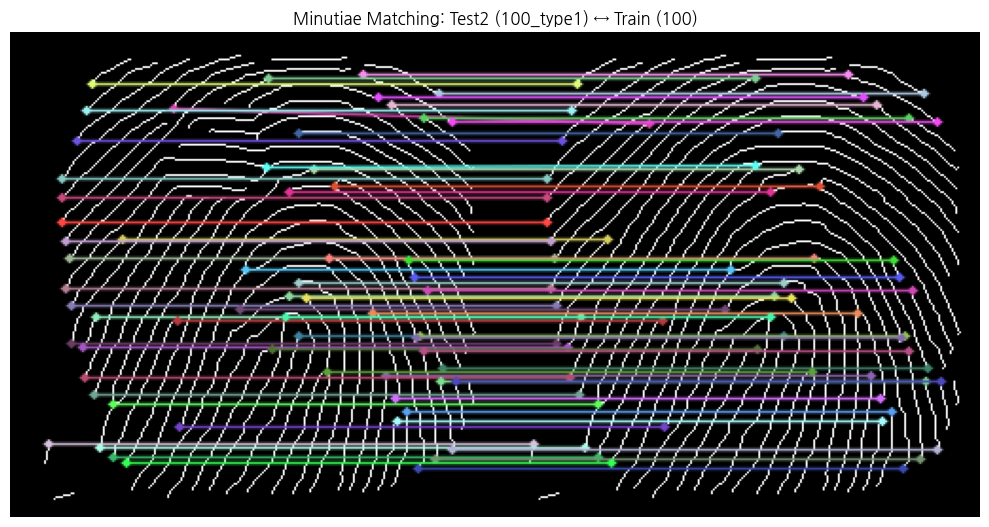

In [ ]:
def match_minutiae_with_distances(pts_test, pts_train, max_distance = 15.0):
    matches = []
    distances = []
    if pts_test.shape[0] == 0 or pts_train.shape[0] == 0:
        return matches, distances
    tree_train = cKDTree(pts_train)
    dists, idxs = tree_train.query(pts_test, k = 1, distance_upper_bound = max_distance)
    used_train = set()
    for i_test, (d, i_train) in enumerate(zip(dists, idxs)):
        if i_train == pts_train.shape[0]:
            continue
        if d <= max_distance and (i_train not in used_train):
            matches.append((i_test, int(i_train)))
            distances.append(float(d))
            used_train.add(i_train)
    return matches, distances

minutiae_train = load_minutiae_coordinates("./minutiae/train_ref")
minutiae_test2 = load_minutiae_coordinates("./minutiae/test2")
list_test2 = sorted(glob("./test2/*.BMP"))
dict_results = {}
for test_path in tqdm(list_test2, desc = "Matching Test2 to Train"):
    test_key_full = splitext(basename(test_path))[0]
    train_key_base = test_key_full.split("_")[0]
    pts_train = minutiae_train[train_key_base]["all_points"]
    pts_test = minutiae_test2[test_key_full]["all_points"]
    matches, distances = match_minutiae_with_distances(pts_test, pts_train, max_distance = 12.0)
    avg_dist = float(np.mean(distances)) if distances else None
    dict_results[test_key_full] = {
        "train_id": train_key_base,
        "num_train_pts": pts_train.shape[0],
        "num_test_pts": pts_test.shape[0],
        "num_matches": len(matches),
        "avg_distance": avg_dist,
    }

for k, v in dict_results.items():
    print(f"{k} : train={v['train_id']}, train_pts={v['num_train_pts']}, "
            f"test_pts={v['num_test_pts']}, matches={v['num_matches']}, "
            f"avg_dist={v['avg_distance']}")

first_test = list_test2[0]
test_key_full = splitext(basename(first_test))[0]
train_key_base = test_key_full.split("_")[0]
img_test = cv2.imread(first_test, cv2.IMREAD_GRAYSCALE)
img_train = cv2.imread(join("train_ref", f"{train_key_base}.BMP"), cv2.IMREAD_GRAYSCALE)
skel_test = cv2.imread(join("processed_images/test2", f"{test_key_full}_skeleton.png"), cv2.IMREAD_GRAYSCALE)
skel_train = cv2.imread(join("processed_images/train_ref", f"{train_key_base}_skeleton.png"), cv2.IMREAD_GRAYSCALE)
pts_test = minutiae_test2[test_key_full]["all_points"]
pts_train = minutiae_train[train_key_base]["all_points"]
matches, _ = match_minutiae_with_distances(pts_test, pts_train, max_distance = 12.0)
vis = visualize_fingerprint_matches(skel_test, pts_test, skel_train, pts_train, matches)
plt.figure(figsize = (10, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Minutiae Matching: Test2 ({test_key_full}) ↔ Train ({train_key_base})")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def compute_avg_distance(pts1, pts2, matches):
    if len(matches) == 0:
        return np.inf
    dists = []
    for (i1, i2) in matches:
        x1, y1 = pts1[i1]
        x2, y2 = pts2[i2]
        dists.append(np.hypot(x1 - x2, y1 - y2))
    return float(np.mean(dists))

def compute_matching_metrics(train_minutiae, test_minutiae, threshold=12.0):
    list_train_keys = sorted(train_minutiae.keys())
    list_test_keys = sorted(test_minutiae.keys())
    TP = FP = TN = FN = 0
    for test_key in list_test_keys:
        true_id = test_key.split("_")[0]
        pts_test = test_minutiae[test_key]["all_points"]
        for train_key in list_train_keys:
            pts_train = train_minutiae[train_key]["all_points"]
            matches = match_minutiae_nearest(pts_test, pts_train, max_distance=threshold)
            avg_dist = compute_avg_distance(pts_test, pts_train, matches)
            is_genuine = (train_key == true_id)
            is_matched = (avg_dist <= threshold)
            if is_genuine:
                if is_matched:
                    TP += 1
                else:
                    FN += 1
            else:
                if is_matched:
                    FP += 1
                else:
                    TN += 1
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    FAR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    FRR = FN / (TP + FN) if (TP + FN) > 0 else 0.0
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total > 0 else 0.0
    return {
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "precision": precision,
        "recall": recall,
        "FAR": FAR,
        "FRR": FRR,
        "accuracy": accuracy
    }

100%|██████████| 11/11 [12:18<00:00, 67.10s/it]


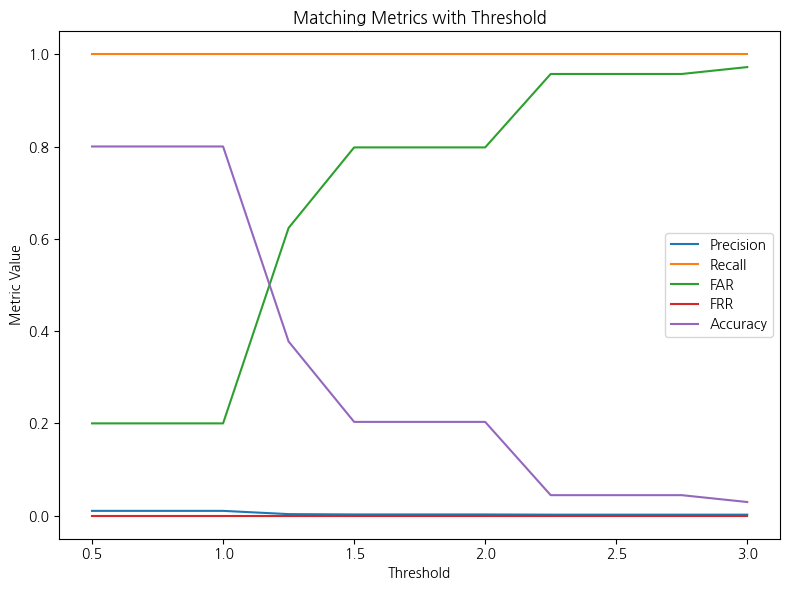

In [ ]:
minutiae_train = load_minutiae_coordinates("./minutiae/train_ref")
minutiae_test2 = load_minutiae_coordinates("./minutiae/test2")

thresholds = np.linspace(0.5, 3.0, 11)
precisions = []
recalls = []
FARs = []
FRRs = []
accuracies = []

for th in tqdm(thresholds):
    metrics = compute_matching_metrics(minutiae_train, minutiae_test2, threshold=th)
    precisions.append(metrics["precision"])
    recalls.append(metrics["recall"])
    FARs.append(metrics["FAR"])
    FRRs.append(metrics["FRR"])
    accuracies.append(metrics["accuracy"])

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, FARs, label="FAR")
plt.plot(thresholds, FRRs, label="FRR")
plt.plot(thresholds, accuracies,label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Matching Metrics with Threshold")
plt.legend()
plt.tight_layout()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

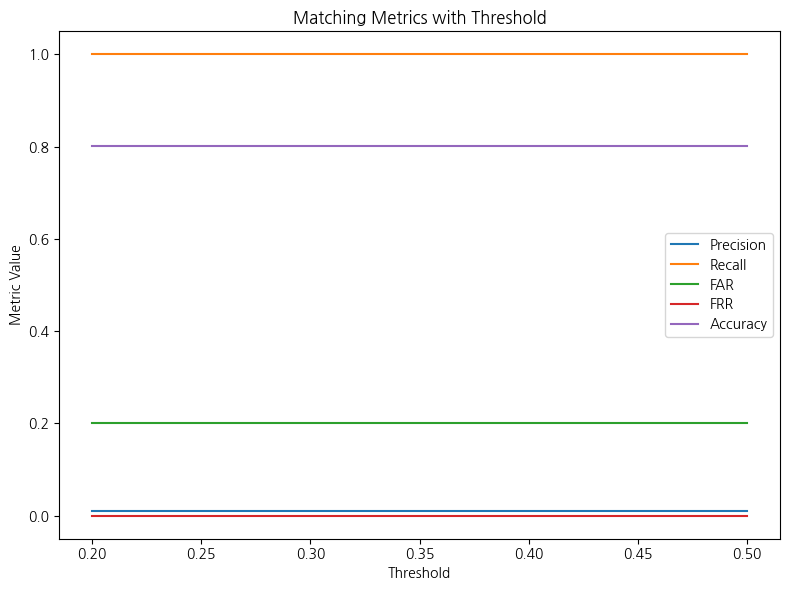

In [ ]:
minutiae_train = load_minutiae_coordinates("./minutiae/train_ref")
minutiae_test2 = load_minutiae_coordinates("./minutiae/test2")

thresholds = np.linspace(0.2, 0.5, 5)
precisions = []
recalls = []
FARs = []
FRRs = []
accuracies = []

for th in tqdm(thresholds):
    metrics = compute_matching_metrics(minutiae_train, minutiae_test2, threshold=th)
    precisions.append(metrics["precision"])
    recalls.append(metrics["recall"])
    FARs.append(metrics["FAR"])
    FRRs.append(metrics["FRR"])
    accuracies.append(metrics["accuracy"])

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, FARs, label="FAR")
plt.plot(thresholds, FRRs, label="FRR")
plt.plot(thresholds, accuracies,label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Matching Metrics with Threshold")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# threshold가 0.5일 때의 매칭 결과

minutiae_train = load_minutiae_coordinates("./minutiae/train_ref")
minutiae_test2 = load_minutiae_coordinates("./minutiae/test2")

threshold = 0.5
metrics = compute_matching_metrics(minutiae_train, minutiae_test2, threshold=threshold)

print(f"Threshold = {threshold}")
print(f"Precision : {metrics['precision']:.4f}")
print(f"Recall : {metrics['recall']:.4f}")
print(f"FAR : {metrics['FAR']:.4f}")
print(f"FRR : {metrics['FRR']:.4f}")
print(f"Accuracy : {metrics['accuracy']:.4f}")

Threshold = 0.5
Precision : 0.0104
Recall : 1.0000
FAR : 0.2001
FRR : 0.0000
Accuracy : 0.8004


# 매칭 (hard)

In [ ]:
device = torch.device("cpu")

class FingerprintPairDataset(Dataset):
    def __init__(self, image_folder, image_size=224, pairs_per_epoch=5000):
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, "*.BMP")))
        self.ids = [os.path.splitext(os.path.basename(p))[0] for p in self.image_paths]
        self.id_to_paths = {}
        for p, id_ in zip(self.image_paths, self.ids):
            base_id = id_.split("_")[0]
            self.id_to_paths.setdefault(base_id, []).append(p)
        self.unique_ids = list(self.id_to_paths.keys())
        self.pairs_per_epoch = pairs_per_epoch
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomRotation(degrees=15, fill=(0,)),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return self.pairs_per_epoch

    def __getitem__(self, idx):
        if random.random() < 0.5:
            base_id = random.choice(self.unique_ids)
            paths = self.id_to_paths[base_id]
            if len(paths) >= 2:
                p1, p2 = random.sample(paths, 2)
            else:
                p1 = p2 = paths[0]
            img1 = Image.open(p1).convert("L")
            img2 = Image.open(p2).convert("L")
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            label = torch.tensor([1.0], dtype=torch.float32)
        else:
            id1, id2 = random.sample(self.unique_ids, 2)
            path1 = random.choice(self.id_to_paths[id1])
            path2 = random.choice(self.id_to_paths[id2])
            img1 = Image.open(path1).convert("L")
            img2 = Image.open(path2).convert("L")
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            label = torch.tensor([0.0], dtype=torch.float32)
        return img1, img2, label

class FingerprintSiameseCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,  32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128,256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256,256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )

    def forward_once(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        emb = self.fc(x)
        return F.normalize(emb, p=2, dim=1)

    def forward(self, input1, input2):
        return self.forward_once(input1), self.forward_once(input2)

class FingerprintSiameseCNNWithAttention(nn.Module):
    def __init__(self, embedding_dim=128, attn_dim=256, num_heads=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,  32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # (B,256,7,7)
        )
        encoder_layer = nn.TransformerEncoderLayer( # Transformer Encoder 레이어
            d_model=attn_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=0.1,
            activation="relu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # (B,256,7,7) => (B, 49, 256) 형태로 만든 뒤 Transformer에 넣기
        self.project = nn.Linear(256, attn_dim) 
        
        self.fc = nn.Sequential(
            nn.Linear(attn_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )
    
    def forward_once(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x) 
        b, c, h, w = x.size()
        x = x.view(b, c, h*w).permute(2, 0, 1) 
        x = self.project(x) 
        x = self.transformer(x) 
        x = x.mean(dim=0)
        emb = self.fc(x)
        emb = F.normalize(emb, p=2, dim=1)
        return emb
    
    def forward(self, input1, input2):
        out1 = self.forward_once(input1)
        out2 = self.forward_once(input2)
        return out1, out2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        dists = F.pairwise_distance(emb1, emb2, keepdim=True)
        pos = label * dists.pow(2)
        neg = (1.0 - label) * F.relu(self.margin - dists).pow(2)
        return torch.mean(pos + neg)
    
def train_siamese_model(
    train_folder,
    use_attention=False,  
    embedding_dim=128,
    batch_size=16,
    num_epochs=20,
    learning_rate=1e-4,
    margin=1.0,
    pairs_per_epoch=5000,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    dataset = FingerprintPairDataset(
        image_folder=train_folder,
        image_size=224,
        pairs_per_epoch=pairs_per_epoch
    )
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0, 
        pin_memory=True
    )
    
    if use_attention:
        model = FingerprintSiameseCNNWithAttention(embedding_dim=embedding_dim).to(device)
    else:
        model = FingerprintSiameseCNN(embedding_dim=embedding_dim).to(device)
    
    criterion = ContrastiveLoss(margin=margin)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        
        for img1, img2, labels in loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(loader)
        print(f"Epoch [{epoch}/{num_epochs}]  Loss: {avg_loss:.6f}")
        
        if epoch % 5 == 0 or epoch == num_epochs:
            if use_attention:
                ckpt_name = f"attn_epoch{epoch}.pth"
            else:
                ckpt_name = f"epoch{epoch}.pth"
            torch.save(model.state_dict(), os.path.join("checkpoints", ckpt_name))
    
    return model


def extract_embeddings(model, folder, img_size=224):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    embs = {}
    with torch.no_grad():
        for p in sorted(glob.glob(os.path.join(folder, "*.BMP"))):
            name = os.path.splitext(os.path.basename(p))[0]
            img = Image.open(p).convert("L")
            inp = transform(img).unsqueeze(0).to(device)
            emb = model.forward_once(inp).cpu().numpy().reshape(-1)
            embs[name] = emb
    return embs

def match_test1_to_train(model, train_folder, test_folder):
    train_embs = extract_embeddings(model, train_folder)
    test_embs  = extract_embeddings(model, test_folder)
    results = {}
    for test_name, test_emb in test_embs.items():
        best_d, best_id = float("inf"), None
        for train_name, train_emb in train_embs.items():
            d = np.linalg.norm(test_emb - train_emb)
            if d < best_d:
                best_d, best_id = d, train_name
        results[test_name] = (best_id, best_d)
    return results

train_folder = "./train_ref"
test1_folder = "./test"

model_cnn = train_siamese_model(train_folder, use_attention=False)
model_cnn_attn = train_siamese_model(train_folder, use_attention=True)

# 쿠다 오류로 실패함. 다음 코드에서 모델 불러오서 결과 확인할 것.. 
res_cnn = match_test1_to_train(model_cnn, train_folder, test1_folder)

correct = 0
for name, (pred, d) in res_cnn.items():
    print(f"{name} -> {pred} (dist={d:.4f})")
    if name.split("_")[0] == pred:
        correct += 1
print(f"CNN accuracy: {correct}/{len(res_cnn)} = {correct/len(res_cnn):.4f}")

res_cnn_attn = match_test1_to_train(model_cnn_attn, train_folder, test1_folder)
correct = 0
for name, (pred, d) in res_cnn_attn.items():
    print(f"{name} -> {pred} (dist={d:.4f})")
    if name.split("_")[0] == pred:
        correct += 1
print(f"CNN with Attention accuracy: {correct}/{len(res_cnn_attn)} = {correct/len(res_cnn_attn):.4f}")

Epoch [1/20] Loss: 0.129700
Epoch [2/20] Loss: 0.083131
Epoch [3/20] Loss: 0.068060
Epoch [4/20] Loss: 0.064057
Epoch [5/20] Loss: 0.059438
Epoch [6/20] Loss: 0.058325
Epoch [7/20] Loss: 0.054451
Epoch [8/20] Loss: 0.050972
Epoch [9/20] Loss: 0.049345
Epoch [10/20] Loss: 0.046545
Epoch [11/20] Loss: 0.051317
Epoch [12/20] Loss: 0.046650
Epoch [13/20] Loss: 0.043728
Epoch [14/20] Loss: 0.044243
Epoch [15/20] Loss: 0.043234
Epoch [16/20] Loss: 0.040704
Epoch [17/20] Loss: 0.040295
Epoch [18/20] Loss: 0.040327
Epoch [19/20] Loss: 0.039801
Epoch [20/20] Loss: 0.040453
Epoch [1/20] Loss: 0.134914
Epoch [2/20] Loss: 0.080019
Epoch [3/20] Loss: 0.068772
Epoch [4/20] Loss: 0.061114
Epoch [5/20] Loss: 0.058937
Epoch [6/20] Loss: 0.055925
Epoch [7/20] Loss: 0.054563
Epoch [8/20] Loss: 0.047502
Epoch [9/20] Loss: 0.047087
Epoch [10/20] Loss: 0.045752
Epoch [11/20] Loss: 0.044436
Epoch [12/20] Loss: 0.044804
Epoch [13/20] Loss: 0.043369
Epoch [14/20] Loss: 0.044397
Epoch [15/20] Loss: 0.042351
Epo

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
model = FingerprintSiameseCNN(embedding_dim=128)
model.load_state_dict(torch.load("checkpoints/epoch20.pth", map_location="cpu"))
model.eval()

res = match_test1_to_train(model, train_folder="./train_ref", test_folder="./test", device="cpu")

correct = 0
for name, (pred, d) in res.items():
    print(f"{name} → {pred} (dist={d:.4f})")
    if name.split("_")[0] == pred:
        correct += 1

print(f"정확도: {correct} / {len(res)} = {correct / len(res):.4f}")

1 → 1 (dist=0.1531)
10 → 195 (dist=0.3549)
100 → 100 (dist=0.2309)
101 → 101 (dist=0.1446)
102 → 102 (dist=0.2049)
104 → 104 (dist=0.2919)
105 → 105 (dist=0.1748)
106 → 106 (dist=0.3143)
107 → 107 (dist=0.1231)
108 → 108 (dist=0.1220)
11 → 11 (dist=0.2082)
111 → 111 (dist=0.1825)
112 → 112 (dist=0.1101)
113 → 113 (dist=0.2453)
116 → 116 (dist=0.0661)
12 → 12 (dist=0.1453)
120 → 120 (dist=0.2040)
122 → 122 (dist=0.0614)
123 → 123 (dist=0.1195)
124 → 124 (dist=0.2345)
125 → 125 (dist=0.1793)
128 → 128 (dist=0.0735)
129 → 129 (dist=0.0520)
131 → 198 (dist=0.1970)
132 → 132 (dist=0.1083)
133 → 133 (dist=0.2212)
134 → 134 (dist=0.0867)
137 → 137 (dist=0.1695)
138 → 138 (dist=0.0460)
139 → 36 (dist=0.2325)
14 → 14 (dist=0.0402)
143 → 143 (dist=0.0507)
144 → 143 (dist=0.2593)
145 → 145 (dist=0.2527)
146 → 146 (dist=0.1049)
147 → 147 (dist=0.2009)
148 → 148 (dist=0.1027)
150 → 578 (dist=0.2590)
151 → 151 (dist=0.2139)
152 → 152 (dist=0.1329)
153 → 153 (dist=0.2994)
155 → 155 (dist=0.0840)
157 

In [ ]:
model = FingerprintSiameseCNNWithAttention(embedding_dim=128)
model.load_state_dict(torch.load("checkpoints/attn_epoch20.pth", map_location="cpu"))
model.eval()

res = match_test1_to_train(model, train_folder="./train_ref", test_folder="./test", device="cpu")

correct = 0
for name, (pred, d) in res.items():
    print(f"{name} → {pred} (dist={d:.4f})")
    if name.split("_")[0] == pred:
        correct += 1

print(f"정확도: {correct} / {len(res)} = {correct / len(res):.4f}")

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


1 → 1 (dist=0.2211)
10 → 10 (dist=0.2037)
100 → 251 (dist=0.2879)
101 → 101 (dist=0.1137)
102 → 102 (dist=0.0915)
104 → 104 (dist=0.2537)
105 → 105 (dist=0.0960)
106 → 106 (dist=0.1707)
107 → 107 (dist=0.1337)
108 → 108 (dist=0.0783)
11 → 11 (dist=0.2191)
111 → 111 (dist=0.1265)
112 → 112 (dist=0.0719)
113 → 113 (dist=0.1179)
116 → 116 (dist=0.0611)
12 → 12 (dist=0.0561)
120 → 120 (dist=0.1982)
122 → 122 (dist=0.0759)
123 → 123 (dist=0.0512)
124 → 124 (dist=0.0806)
125 → 125 (dist=0.1325)
128 → 128 (dist=0.2718)
129 → 129 (dist=0.0599)
131 → 131 (dist=0.2405)
132 → 132 (dist=0.0937)
133 → 133 (dist=0.1891)
134 → 134 (dist=0.1387)
137 → 137 (dist=0.2483)
138 → 138 (dist=0.1042)
139 → 139 (dist=0.3164)
14 → 14 (dist=0.0717)
143 → 143 (dist=0.0671)
144 → 144 (dist=0.1396)
145 → 342 (dist=0.2892)
146 → 146 (dist=0.1117)
147 → 147 (dist=0.1790)
148 → 148 (dist=0.0694)
150 → 150 (dist=0.1682)
151 → 151 (dist=0.0756)
152 → 152 (dist=0.1026)
153 → 153 (dist=0.1210)
155 → 155 (dist=0.1166)
157 